In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split,GridSearchCV
import pyarrow
import sys
import os

from sklearn.svm import SVC

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))
# from Utils.constants import DATASETS_FOLDER_PATH
from Utils.constants import CLASSIFIERS_COLUMN
from sklearn.ensemble import RandomForestClassifier
from Utils.data_utils import *
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [2]:
df = load_data_from_folder()
df = df.drop(columns=['file_name'])
print('shape =',df.shape)

df.describe()

shape = (6552, 10)


ph     Hardness        Solids  Chloramines      Sulfate  \
count  5570.000000  6552.000000   6552.000000  6552.000000  4990.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594176    32.877252   8767.901548     1.582964    41.412689   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.697010   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950968   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   6552.000000     6552.000000      6228.000000  6552.000000  6552.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.817895        3.307909        16.173710     0.780323     0.487812  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.835966     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.339918     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6552 entries, 0 to 6551
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               5570 non-null   float64
 1   Hardness         6552 non-null   float64
 2   Solids           6552 non-null   float64
 3   Chloramines      6552 non-null   float64
 4   Sulfate          4990 non-null   float64
 5   Conductivity     6552 non-null   float64
 6   Organic_carbon   6552 non-null   float64
 7   Trihalomethanes  6228 non-null   float64
 8   Turbidity        6552 non-null   float64
 9   Potability       6552 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 512.0 KB


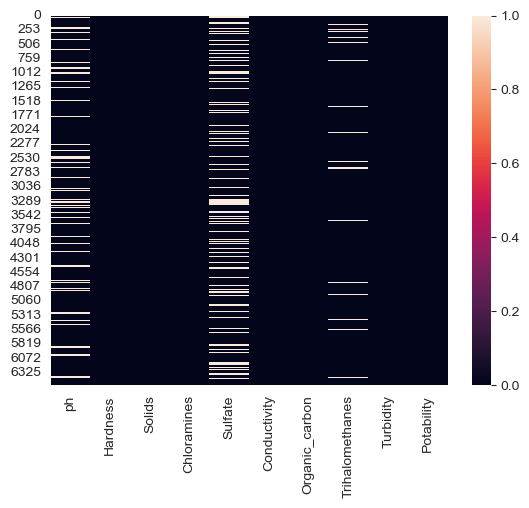

In [4]:
sns.heatmap(df.isnull());

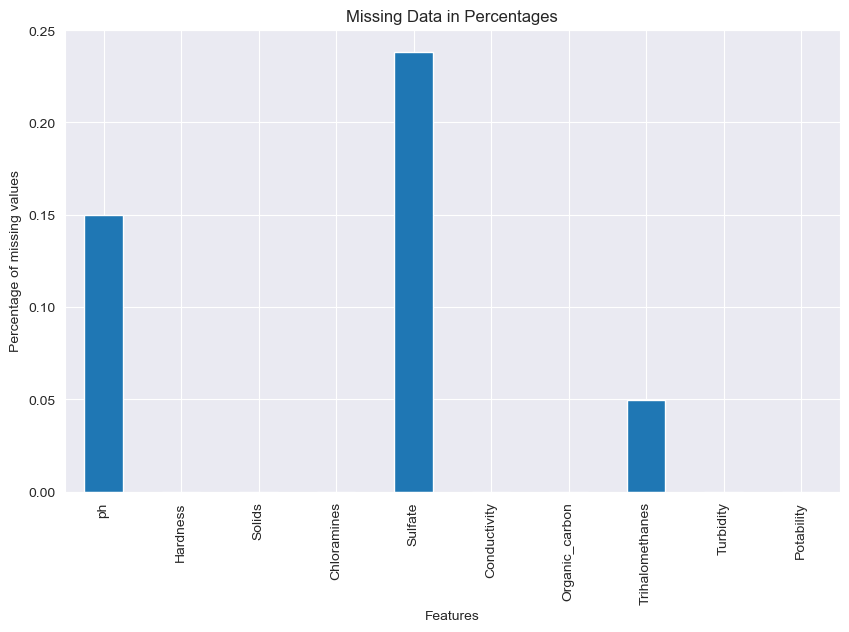

In [5]:
df.isnull().mean().plot.bar(figsize=(10,6)) 
plt.ylabel('Percentage of missing values') 
plt.xlabel('Features') 
plt.title('Missing Data in Percentages');

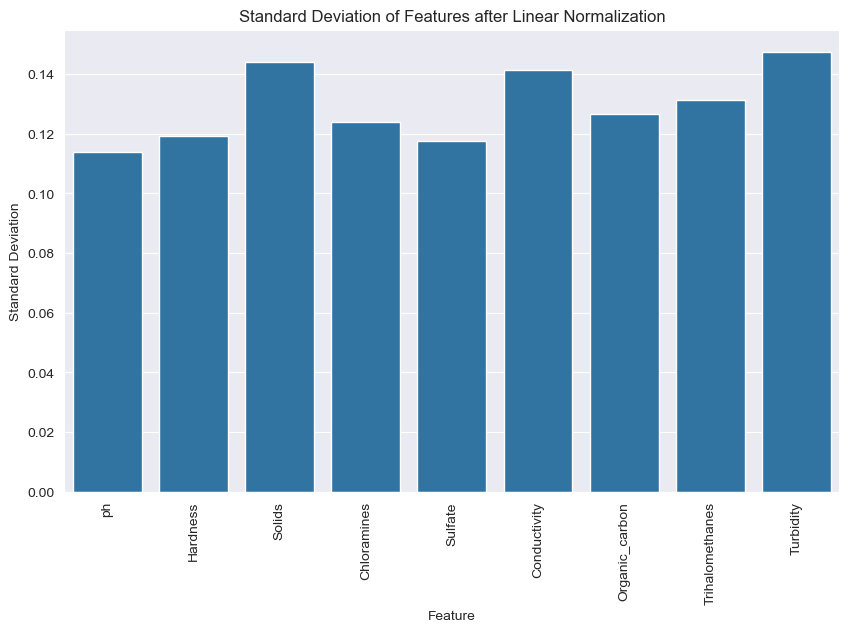

In [6]:
# Assuming df is your DataFrame containing the data
df_features = df.iloc[:, :-1]
normalized_mX = (df_features - df_features.min()) / (df_features.max() - df_features.min())  # Linearly normalize each feature to have a max of 1
std = normalized_mX.std()  # Calculate the standard deviation of each feature

# Plot the standard deviation of each feature after linear normalization
plt.figure(figsize=(10, 6))
sns.barplot(x=std.index, y=std.values)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Features after Linear Normalization')
plt.show()

(6552, 10)


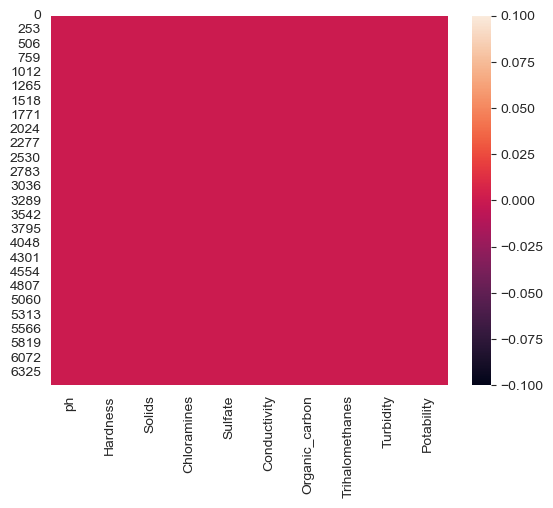

In [7]:
# clean data - after cleaning
df_clean = normalized_mX.copy()
df_clean = pd.concat([df_clean, df['Potability']], axis=1) # add back potability column

# remove null rows
# df_clean.dropna(inplace=True)

# mean null rows
# df_clean.fillna(normalized_df.mean(), inplace=True)

# KNN Imputer
imputer = KNNImputer(n_neighbors=5) # Create a KNN imputer
df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)

# Iterative Imputer
# imputer = IterativeImputer(random_state=0, skip_complete=True)  # Create an IterativeImputer
# df_clean = pd.DataFrame(imputer.fit_transform(df_clean), columns=df_clean.columns)


print(df_clean.shape)

sns.heatmap(df_clean.isnull());

In [8]:
vY = df_clean[CLASSIFIERS_COLUMN]
mX = df_clean.drop(CLASSIFIERS_COLUMN,axis=1)

In [9]:
def normalize_df(df):
    # Calculate Z-scores for each column
    z_scores = (df - df.mean()) / df.std()
    
    return z_scores

In [10]:
def visualize_outliers(normalized_df, threshold=3):
    # Identify outliers
    outliers = (np.abs(normalized_df) > threshold)
    
    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=len(normalized_df.columns), figsize=(15, 5))
    fig.suptitle('Visualizing Outliers')

    for i, col in enumerate(normalized_df.columns):
        ax = axes[i] if len(normalized_df.columns) > 1 else axes
        ax.scatter(range(len(normalized_df)), normalized_df[col], label=col)
        ax.scatter(outliers.index[outliers[col]], normalized_df[col][outliers[col]], color='red', label='Outliers')
        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.set_title(col)
        ax.legend()

    plt.tight_layout()
    plt.show()

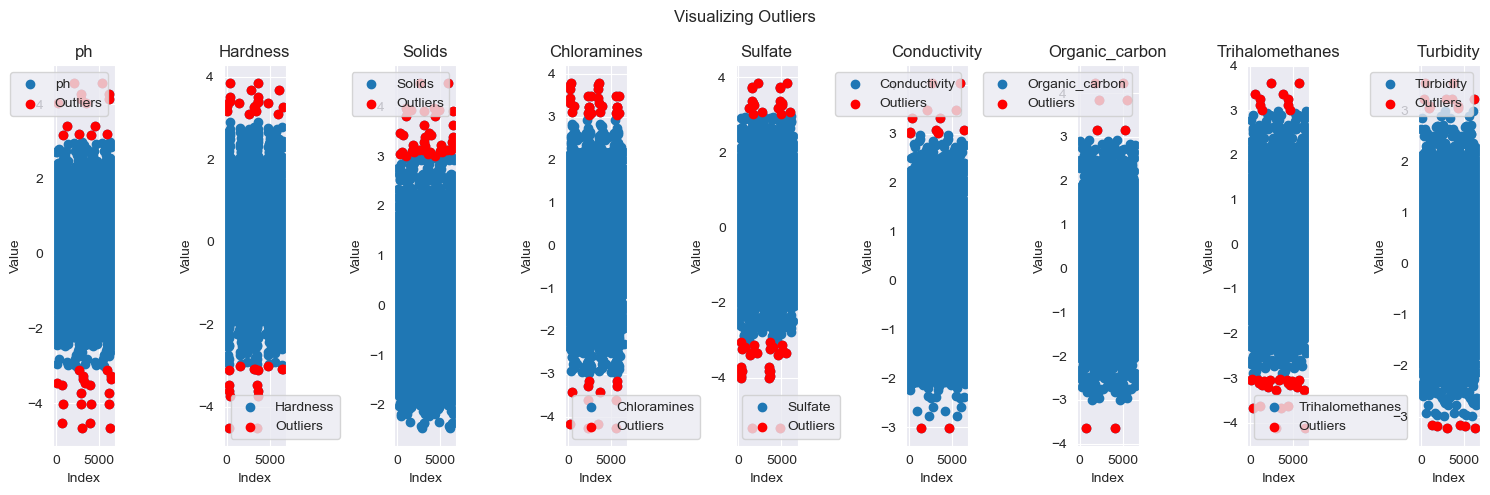

In [11]:
normalized_mX = normalize_df(mX)
visualize_outliers(normalized_mX, threshold=3)

In [12]:
def count_rows_with_outliers(df, threshold=3):
    outliers_mask = (np.abs(df) > threshold).any(axis=1)
    num_rows_with_outliers = outliers_mask.sum()
    return num_rows_with_outliers

def count_outliers_per_column(df, threshold=3):
    outliers_per_column = (np.abs(df) > threshold).sum()
    return outliers_per_column

In [13]:
count_rows_with_outliers(normalized_mX, threshold=3)

254

In [14]:
count_outliers_per_column(normalized_mX)

ph                 34
Hardness           36
Solids             40
Chloramines        40
Sulfate            46
Conductivity       14
Organic_carbon      8
Trihalomethanes    34
Turbidity          16
dtype: int64

In [15]:
def remove_outliers(df, threshold=3):
    z_scores = (df - df.mean()) / df.std()
    outliers_mask = (np.abs(z_scores) > threshold).any(axis=1)
    df_cleaned = df[~outliers_mask]
    return df_cleaned

In [16]:
normalized_df = pd.concat([normalized_mX, vY], axis=1)
df_without_outliers = remove_outliers(normalized_df, threshold=3)

In [17]:
def balance_df_with_smote(df, target_column):
    # Separate features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Apply SMOTE to balance the dataset
    smote = SMOTE(sampling_strategy='auto', random_state=42 , k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    # Combine balanced features and target variable into a DataFrame
    balanced_df = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.Series(y_balanced, name=target_column)], axis=1)
    
    return balanced_df

In [18]:
df_without_outliers

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0    -0.279375  0.259175 -0.139460     0.112406  0.911410      1.708824   
1    -2.217594 -2.036258 -0.385957    -0.307670  0.875502      2.062418   
2     0.674814  0.847600 -0.240029     1.360490 -0.208428     -0.094025   
3     0.818438  0.547610  0.000493     0.591963  0.607065     -0.778771   
4     1.330169 -0.464394 -0.460213    -0.363670 -0.616313     -0.343913   
...        ...       ...       ...          ...       ...           ...   
6547 -1.589346 -0.081751  2.915966     0.028025  0.687203      1.240060   
6548  0.483264 -0.085661 -0.534254     0.593245  0.221504     -0.417674   
6549  1.546148 -0.626781  1.270713     0.144006 -0.289976      0.072257   
6550 -1.286672  1.041275 -1.143971    -0.517333 -1.611525     -0.288575   
6551  0.526696 -0.038543 -0.525772     0.244496 -0.319907     -1.221825   

      Organic_carbon  Trihalomethanes  Turbidity  Potability  
0          -1.180560         1.291235  -1.286199         0.0  
1           0.270577        -0.634285   0.684166         0.0  
2           0.781057        -0.000585  -1.167276         0.0  
3           1.255039         2.129639   0.848347         0.0  
4          -0.824294        -2.162240   0.138775         0.0  
...              ...              ...        ...         ...  
6547       -0.118066         0.016220   0.601078         1.0  
6548        1.698431         0.761858  -1.497513         1.0  
6549       -0.981254         0.214519  -0.855941         1.0  
6550       -0.941992         0.694476   0.950725         1.0  
6551        0.560897         0.770477  -2.124297         1.0  

[6298 rows x 10 columns]

In [19]:
df_balanced = balance_df_with_smote(df_without_outliers,'Potability')

<module 'matplotlib.pyplot' from 'C:\\Users\\yuval.yarom\\AppData\\Local\\mambaforge\\envs\\Predicting-Drinking-Water-Potability\\Lib\\site-packages\\matplotlib\\pyplot.py'>

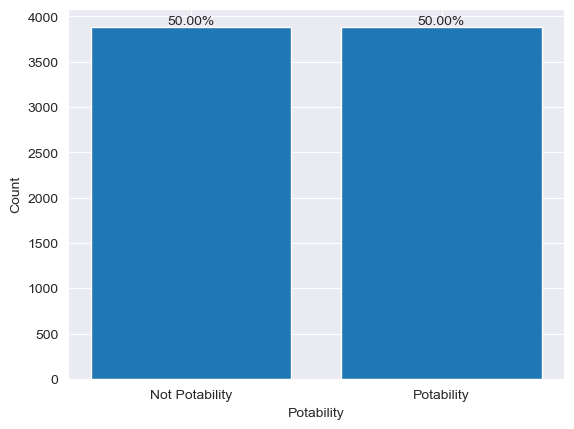

In [20]:
from Utils.DataVisualization import * 
get_balance_plot(df_balanced,'Potability')

In [21]:
def calculate_wqi(df, parameters, standards, weights):
    # Check if DataFrame contains all parameters
    missing_params = [param for param in parameters if param not in df.columns]
    if missing_params:
        raise ValueError(f"DataFrame is missing parameters: {', '.join(missing_params)}")

    # Calculate sub-indices for each parameter
    sub_indices = {param: df[param] / standards[param] for param in parameters}

    # Calculate WQI for each row
    wqi_values = []
    for index, row in df.iterrows():
        weighted_sum = sum(sub_indices[param][index] * weights[param] for param in parameters)
        wqi_values.append(weighted_sum)

    # Add WQI column to DataFrame
    df['WQI'] = wqi_values

    return df

In [22]:
standards = {
    'ph': 7,
    'Hardness': 200,
    'Solids': 200,
    'Chloramines': 0.8,
    'Sulfate': 250,
    'Conductivity': 600,
    'Organic_carbon': 8,
    'Trihalomethanes': 13,
    'Turbidity': 2
}
# weights = {
#     'ph': 0.229240,
#     'Hardness': 0.113918,
#     'Solids': 0.135622,
#     'Chloramines': 0.113747,
#     'Sulfate': 0.218921,
#     'Conductivity': 0.046059,
#     'Organic_carbon': 0.060725,
#     'Trihalomethanes': 0.048147,
#     'Turbidity': 0.033621
# }

weights = {
    'ph': 0.1,
    'Hardness': 0.1,
    'Solids': 0.1,
    'Chloramines': 0.1,
    'Sulfate': 0.1,
    'Conductivity': 0.1,
    'Organic_carbon': 0.1,
    'Trihalomethanes': 0.1,
    'Turbidity': 0.1
}

In [23]:
df_with_wqi = calculate_wqi(df_balanced, parameters=['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity'], standards=standards, weights=weights)
df_with_wqi

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0    -0.279375  0.259175 -0.139460     0.112406  0.911410      1.708824   
1    -2.217594 -2.036258 -0.385957    -0.307670  0.875502      2.062418   
2     0.674814  0.847600 -0.240029     1.360490 -0.208428     -0.094025   
3     0.818438  0.547610  0.000493     0.591963  0.607065     -0.778771   
4     1.330169 -0.464394 -0.460213    -0.363670 -0.616313     -0.343913   
...        ...       ...       ...          ...       ...           ...   
7763  0.190789  1.220497  0.391185    -0.364516  0.731549      0.309799   
7764 -0.270387 -1.138756  2.253770    -2.595055 -2.495407      1.300521   
7765 -0.445208  0.361021  0.688991    -0.743892  0.275921      0.123408   
7766  0.509408  0.764359  0.645899    -0.183763  0.154218     -1.355422   
7767 -0.601444  0.158242 -0.729474    -0.263472  0.876790     -0.819783   

      Organic_carbon  Trihalomethanes  Turbidity  Potability       WQI  
0          -1.180560         1.291235  -1.286199         0.0 -0.058365  
1           0.270577        -0.634285   0.684166         0.0 -0.037944  
2           0.781057        -0.000585  -1.167276         0.0  0.131301  
3           1.255039         2.129639   0.848347         0.0  0.160562  
4          -0.824294        -2.162240   0.138775         0.0 -0.047220  
...              ...              ...        ...         ...       ...  
7763        1.087543        -0.665776   0.397494         1.0 -0.013341  
7764        1.062510        -0.172893   2.088235         1.0 -0.212105  
7765        0.603442        -0.091986   0.446590         1.0 -0.069526  
7766       -0.044070        -2.001716   1.115893         1.0  0.024694  
7767       -1.010909        -2.607043   0.780559         1.0 -0.035260  

[7768 rows x 11 columns]

In [24]:
df_balanced

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0    -0.279375  0.259175 -0.139460     0.112406  0.911410      1.708824   
1    -2.217594 -2.036258 -0.385957    -0.307670  0.875502      2.062418   
2     0.674814  0.847600 -0.240029     1.360490 -0.208428     -0.094025   
3     0.818438  0.547610  0.000493     0.591963  0.607065     -0.778771   
4     1.330169 -0.464394 -0.460213    -0.363670 -0.616313     -0.343913   
...        ...       ...       ...          ...       ...           ...   
7763  0.190789  1.220497  0.391185    -0.364516  0.731549      0.309799   
7764 -0.270387 -1.138756  2.253770    -2.595055 -2.495407      1.300521   
7765 -0.445208  0.361021  0.688991    -0.743892  0.275921      0.123408   
7766  0.509408  0.764359  0.645899    -0.183763  0.154218     -1.355422   
7767 -0.601444  0.158242 -0.729474    -0.263472  0.876790     -0.819783   

      Organic_carbon  Trihalomethanes  Turbidity  Potability       WQI  
0          -1.180560         1.291235  -1.286199         0.0 -0.058365  
1           0.270577        -0.634285   0.684166         0.0 -0.037944  
2           0.781057        -0.000585  -1.167276         0.0  0.131301  
3           1.255039         2.129639   0.848347         0.0  0.160562  
4          -0.824294        -2.162240   0.138775         0.0 -0.047220  
...              ...              ...        ...         ...       ...  
7763        1.087543        -0.665776   0.397494         1.0 -0.013341  
7764        1.062510        -0.172893   2.088235         1.0 -0.212105  
7765        0.603442        -0.091986   0.446590         1.0 -0.069526  
7766       -0.044070        -2.001716   1.115893         1.0  0.024694  
7767       -1.010909        -2.607043   0.780559         1.0 -0.035260  

[7768 rows x 11 columns]

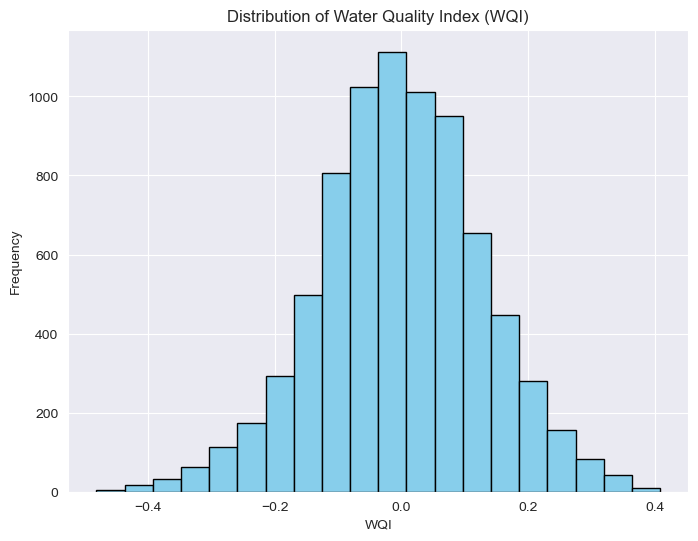

In [25]:
def plot_wqi_distribution(df):
    # Plot histogram of WQI values
    plt.figure(figsize=(8, 6))
    plt.hist(df['WQI'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Water Quality Index (WQI)')
    plt.xlabel('WQI')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage
# Assuming 'df_with_wqi' is your DataFrame containing the WQI column
plot_wqi_distribution(df_with_wqi)

In [26]:
type(df_with_wqi)

pandas.core.frame.DataFrame

In [27]:
df_with_wqi.shape

(7768, 11)

In [28]:
df_with_wqi

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0    -0.279375  0.259175 -0.139460     0.112406  0.911410      1.708824   
1    -2.217594 -2.036258 -0.385957    -0.307670  0.875502      2.062418   
2     0.674814  0.847600 -0.240029     1.360490 -0.208428     -0.094025   
3     0.818438  0.547610  0.000493     0.591963  0.607065     -0.778771   
4     1.330169 -0.464394 -0.460213    -0.363670 -0.616313     -0.343913   
...        ...       ...       ...          ...       ...           ...   
7763  0.190789  1.220497  0.391185    -0.364516  0.731549      0.309799   
7764 -0.270387 -1.138756  2.253770    -2.595055 -2.495407      1.300521   
7765 -0.445208  0.361021  0.688991    -0.743892  0.275921      0.123408   
7766  0.509408  0.764359  0.645899    -0.183763  0.154218     -1.355422   
7767 -0.601444  0.158242 -0.729474    -0.263472  0.876790     -0.819783   

      Organic_carbon  Trihalomethanes  Turbidity  Potability       WQI  
0          -1.180560         1.291235  -1.286199         0.0 -0.058365  
1           0.270577        -0.634285   0.684166         0.0 -0.037944  
2           0.781057        -0.000585  -1.167276         0.0  0.131301  
3           1.255039         2.129639   0.848347         0.0  0.160562  
4          -0.824294        -2.162240   0.138775         0.0 -0.047220  
...              ...              ...        ...         ...       ...  
7763        1.087543        -0.665776   0.397494         1.0 -0.013341  
7764        1.062510        -0.172893   2.088235         1.0 -0.212105  
7765        0.603442        -0.091986   0.446590         1.0 -0.069526  
7766       -0.044070        -2.001716   1.115893         1.0  0.024694  
7767       -1.010909        -2.607043   0.780559         1.0 -0.035260  

[7768 rows x 11 columns]

In [29]:
df_with_wqi.shape

(7768, 11)

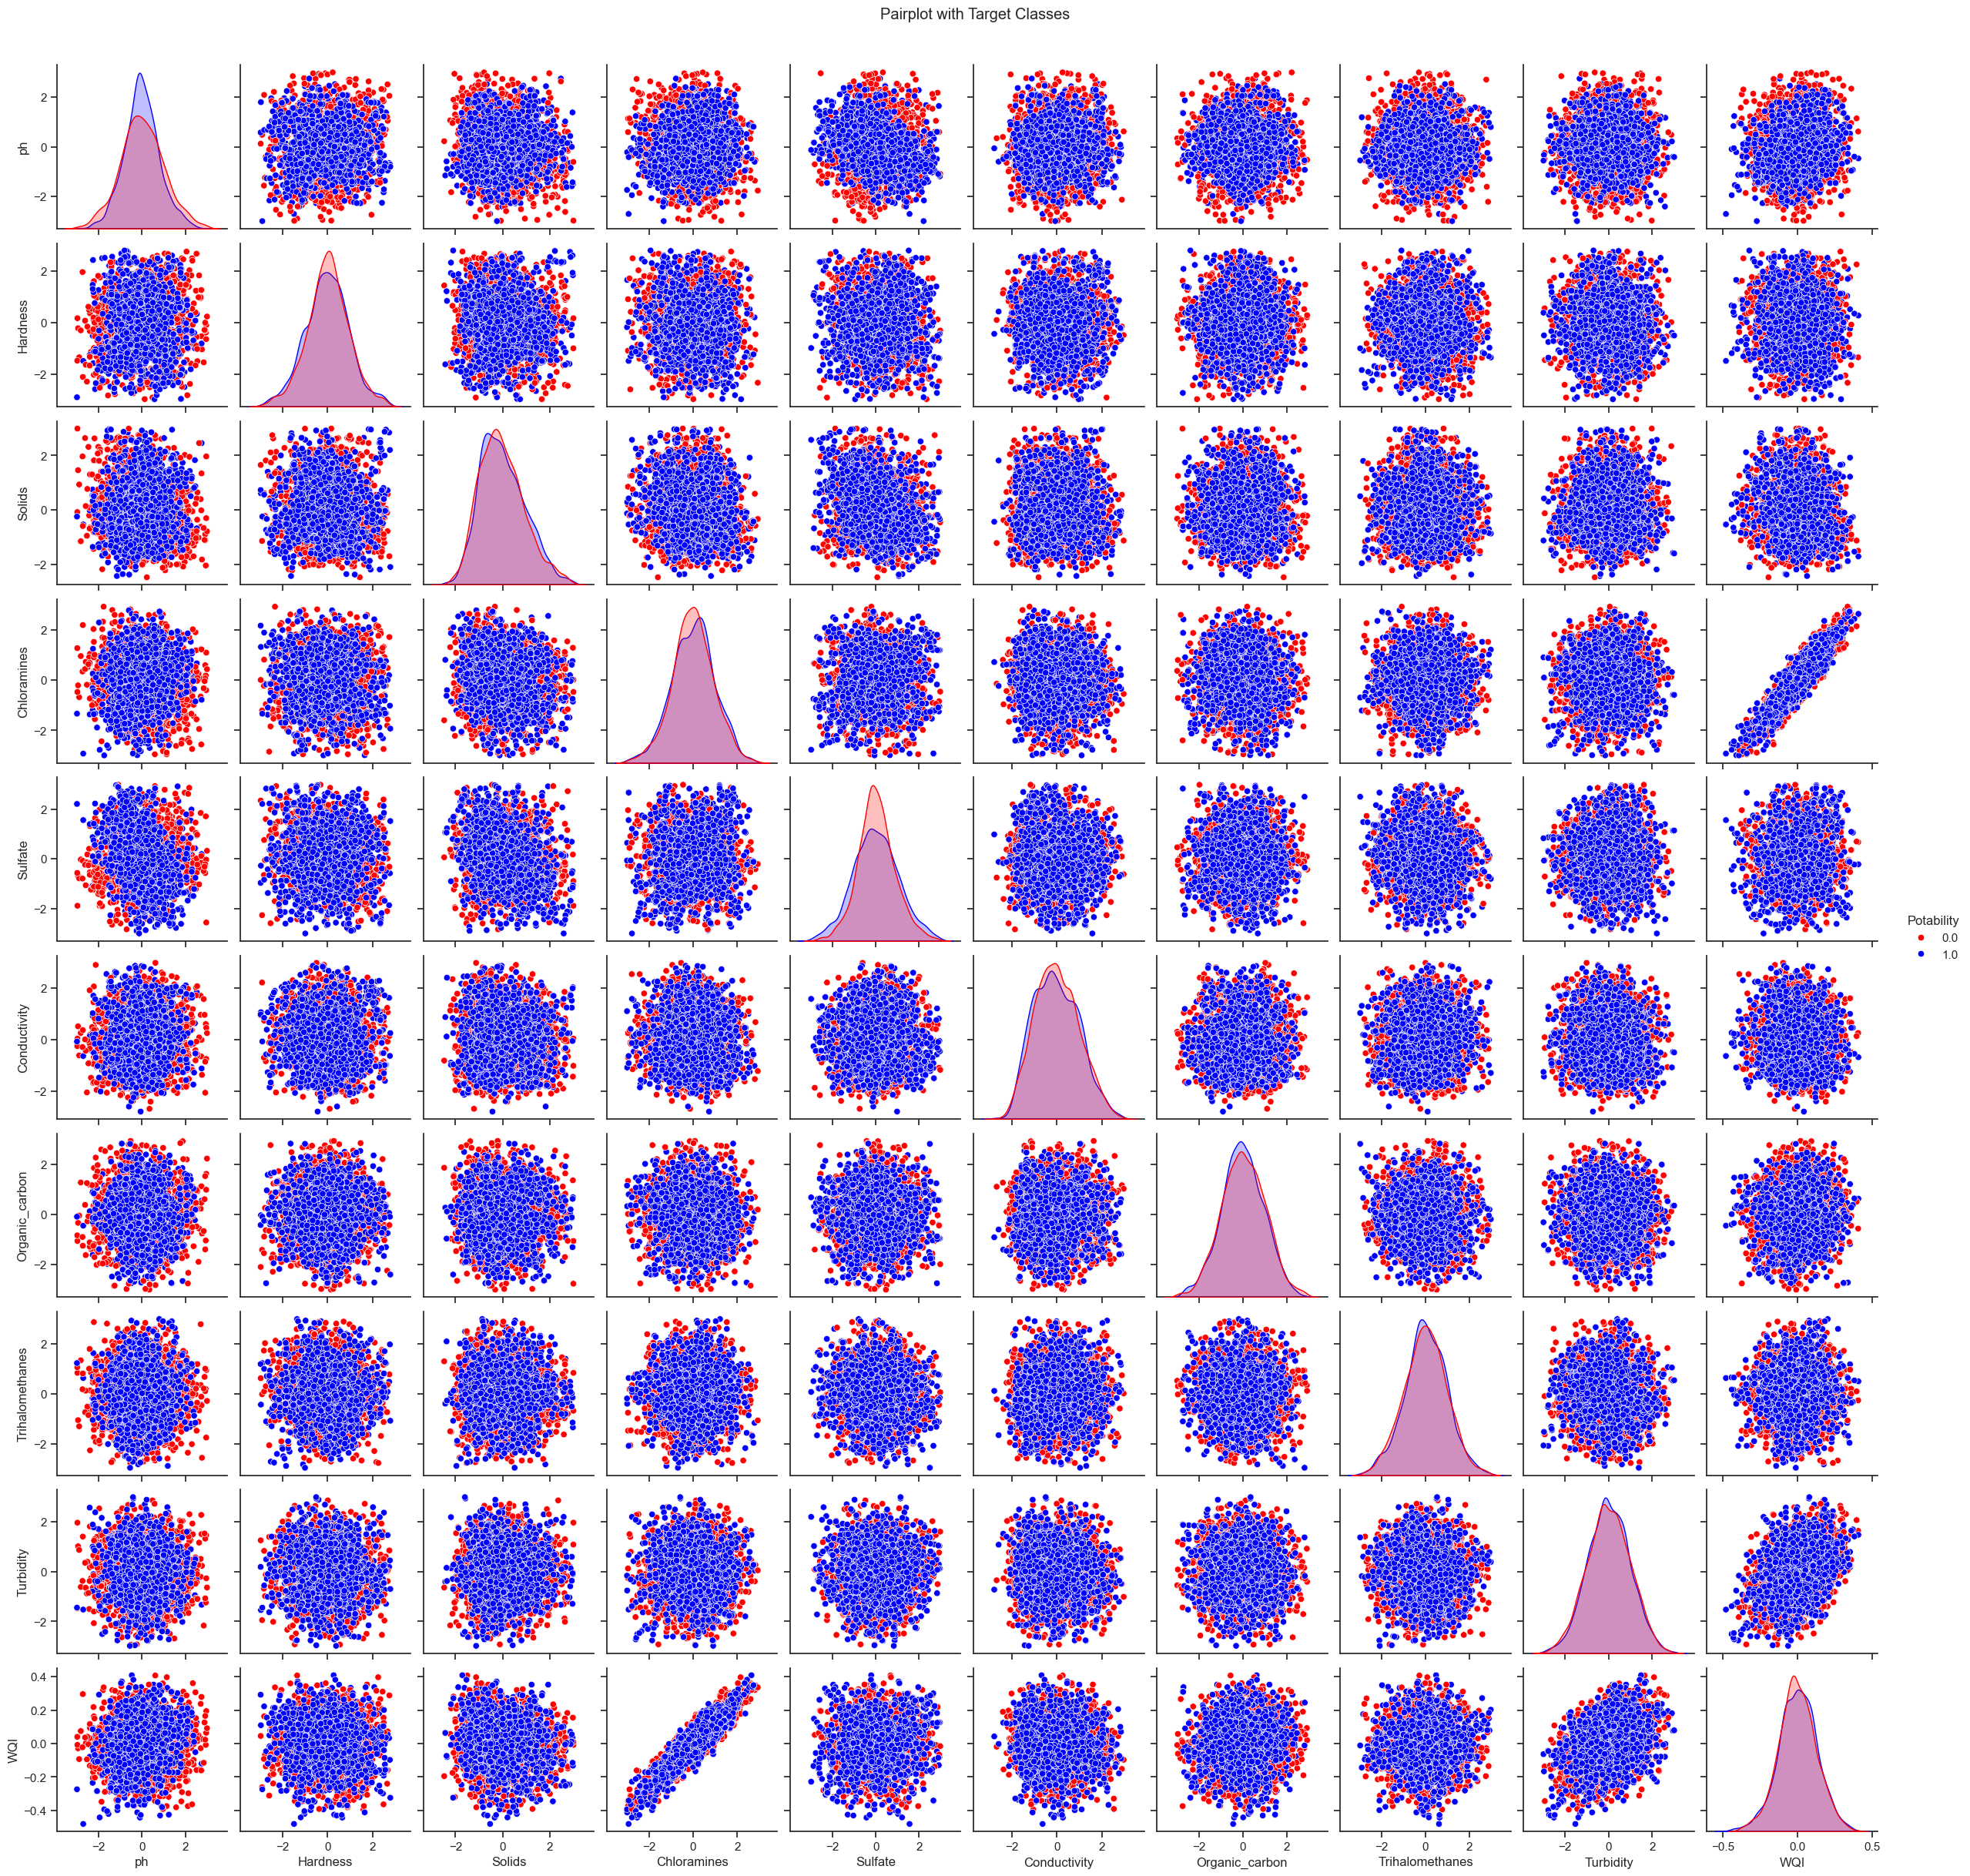

In [30]:
pairplot = get_pairplot(df_with_wqi,CLASSIFIERS_COLUMN)
pairplot

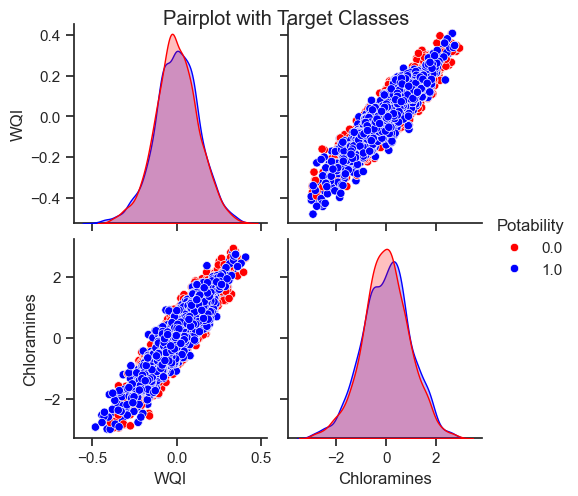

In [31]:
pairplot = get_pairplot(df_with_wqi[['WQI','Chloramines','Potability']],CLASSIFIERS_COLUMN)
pairplot

<Axes: >

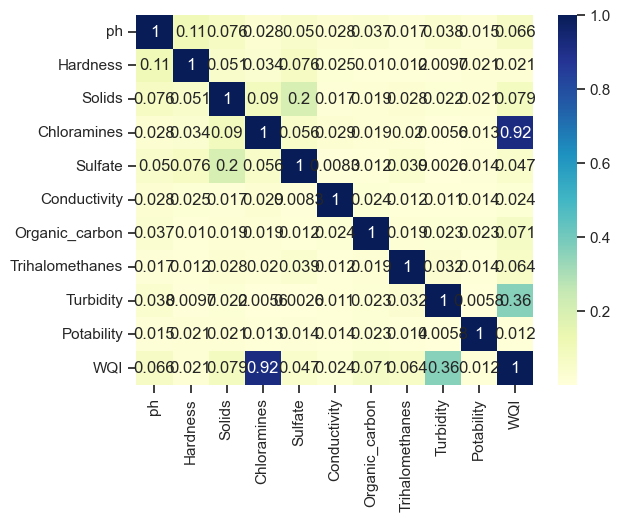

In [32]:
get_corraletion_metrix(df_with_wqi)

<module 'matplotlib.pyplot' from 'C:\\Users\\yuval.yarom\\AppData\\Local\\mambaforge\\envs\\Predicting-Drinking-Water-Potability\\Lib\\site-packages\\matplotlib\\pyplot.py'>

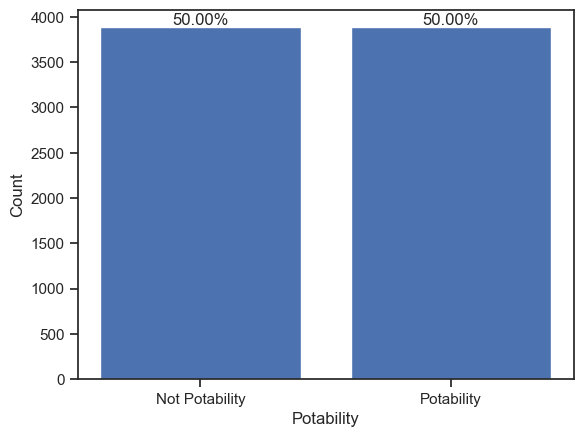

In [33]:
get_balance_plot(df_with_wqi,'Potability')

In [34]:
df_train , df_test = train_test_split(df_with_wqi,train_size=0.3,test_size=0.7, shuffle = True, stratify = df_with_wqi['Potability'])

In [35]:
df_test

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
7488 -0.145722  1.345081 -1.612691     1.307719  2.530232      0.062374   
4280 -0.767196  0.581812 -1.018197     0.418502  0.026130     -1.766981   
6868 -1.058545 -0.525013 -0.181753     1.196598  2.842394     -0.312972   
3274 -0.285477 -1.352908 -1.266540    -2.130593 -2.427132      0.144818   
2403 -0.331573 -0.286681  0.080945    -0.574879 -0.075834     -0.509617   
...        ...       ...       ...          ...       ...           ...   
1131 -0.767196  0.581812 -1.018197     0.418502  0.026130     -1.766981   
1024 -0.145474 -0.718979  0.784724    -1.813914 -2.339509      1.650924   
5530 -0.858677 -0.810327 -0.832967     0.088147  0.669367      1.354248   
6062 -1.178948 -0.657934  0.762202     0.937806 -0.436256      0.674050   
5589  0.136850  0.037492  0.125276     1.503845 -0.035475      0.286528   

      Organic_carbon  Trihalomethanes  Turbidity  Potability       WQI  
7488        1.304483        -1.384393   0.149030         1.0  0.175380  
4280        0.120502        -0.697254   2.155287         1.0  0.144758  
6868       -0.987325        -0.311295   0.081320         1.0  0.124514  
3274        0.296191        -0.139754  -0.197141         0.0 -0.279888  
2403       -0.671855         0.387207   1.295025         0.0 -0.017483  
...              ...              ...        ...         ...       ...  
1131        0.120502        -0.697254   2.155287         1.0  0.144758  
1024        2.133033        -0.951692  -1.290538         1.0 -0.274630  
5530       -0.759545         0.054496   1.534588         0.0  0.066078  
6062       -0.162238        -0.876261  -0.556774         0.0  0.063766  
5589        0.052487         0.224242  -0.506103         0.0  0.167126  

[5438 rows x 11 columns]

<module 'matplotlib.pyplot' from 'C:\\Users\\yuval.yarom\\AppData\\Local\\mambaforge\\envs\\Predicting-Drinking-Water-Potability\\Lib\\site-packages\\matplotlib\\pyplot.py'>

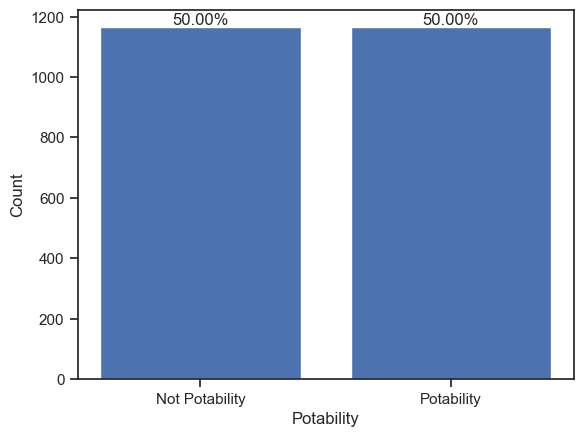

In [36]:
get_balance_plot(df_train,'Potability')

In [41]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, precision_recall_fscore_support


def svm_model(train_df, test_df):
    # Extracting features and target variable from train and test DataFrames
    X_train = train_df.drop(columns=[CLASSIFIERS_COLUMN])
    y_train = train_df[CLASSIFIERS_COLUMN]
    X_test = test_df.drop(columns=[CLASSIFIERS_COLUMN])
    y_test = test_df[CLASSIFIERS_COLUMN]
    
    # Initializing and fitting logistic regression model
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],            # Regularization parameter
        'kernel': ['linear', 'rbf', 'poly'],      # Kernel type
        'gamma': ['scale', 'auto']                # Kernel coefficient for 'rbf' and 'poly'
    }
    vC = [0.001, 0.01, 0.1, 1, 10]
    vGamma = ['scale','auto',0.001, 0.01, 0.1, 1, 10]
    param_grid = [
        {'kernel':['linear'], 'C':vC},
        {'kernel':['poly'], 'C':vC,'degree':[2, 3,4],'gamma':vGamma},
        {'kernel':['rbf'], 'C':vC, 'gamma':vGamma,},
        {'kernel':['sigmoid'], 'C':vC, 'gamma':vGamma,},
    ]
    
    # Initialize SVC model
    svc = SVC()
    
    # Perform grid search cross-validation to find best hyperparameters
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', n_jobs=-1,refit=True)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    # Get the best hyperparameters
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred, average='binary')

    # Compute average scores
    
    
    return best_model, f1, precision, recall

In [42]:
trained_model, f1, precision, recall = svm_model(df_train, df_test)
print("F1 Test Score:", f1)
print("Precision Test Score:", precision)
print("Recall Test Score:", recall)


KeyboardInterrupt: 

In [ ]:
trained_model.get_params()